In [3]:
%config InlineBackend.figure_formats = ['svg']
%matplotlib inline

In [4]:
import numpy as np
import matplotlib.pyplot as plt
import random
import pandas as pd

## Plot functions

In [5]:
def plot_q_values(env, Q):
    fig, axs = plt.subplots(2, 2, figsize=(10, 8))
    axs = axs.flatten()  

    for i, action in enumerate(env.actions):
        heatmap_data = Q[:, :, i] 
        vmin = heatmap_data.min()
        vmax = heatmap_data.max()
        im = axs[i].imshow(heatmap_data, cmap='gray', vmin=vmin, vmax=vmax) 

        for row in range(env.height):
            for col in range(env.width):
                text = axs[i].text(col, row, f"{heatmap_data[row, col]:.2f}",
                                   ha="center", va="center", color="w") 

        axs[i].set_title(f"Q-values for Action: {action}")
        axs[i].set_xticks(range(env.width))
        axs[i].set_yticks(range(env.height))

    plt.suptitle("Q-value Heatmaps for Each Action (Grayscale)")
    plt.tight_layout()
    plt.show()

In [6]:
def test_and_plot(env, method, num_episodes, num_runs=100, alphas = [0.1, 0.3, 0.5], epsilons=[0.01, 0.05, 0.1], title=None):
    alpha_values = alphas
    epsilon_values = epsilons

    results = []

    for alpha in alpha_values:
        for epsilon in epsilon_values:
            rewards_all_runs = []
            print(f"Running for alpha={alpha}, epsilon={epsilon}")
            for _ in range(num_runs):
                rewards = method(env, num_episodes=num_episodes, alpha=alpha, gamma=1, epsilon=epsilon)[-1]
                rewards_all_runs.append(rewards)

            avg_rewards = np.mean(rewards_all_runs, axis=0)
            result = [avg_rewards, alpha, epsilon]  
            results.append(result)

    fig, ax = plt.subplots(figsize=(10, 6)) 

    for rewards, alpha, epsilon in results:
        if alpha is None:
            alpha = "Adaptive"
        ax.plot(rewards, label=f"alpha={alpha}, epsilon={epsilon}")  

    ax.set_xlabel("Episodes")
    ax.set_ylabel("Average Cumulative Reward")  
    ax.legend()
    if title:
        ax.set_title(title)
    else:
        ax.set_title("Average Cumulative Reward vs Episodes for Different Hyperparameters")
    plt.show()

In [7]:
class CliffWalkingEnv:
    def __init__(self, width=12, height=4):
        self.width = width
        self.height = height
        self.start_state = (3, 0)
        self.goal_state = (3, 11)
        self.cliff_states = [(3, 1), (3, 2), (3,3), (3,4), (3,5), (3,6), (3,7), (3,8), (3,9), (3, 10)]

        self.actions = ["UP", "RIGHT", "DOWN", "LEFT"]
        self.action_map = {
            "UP": (-1, 0),
            "DOWN": (1, 0),
            "LEFT": (0, -1),
            "RIGHT": (0, 1)
        }
        self.reset()

    def reset(self):
        self.current_state = self.start_state
        return self.current_state

    def step(self, action):
        delta_row, delta_col = self.action_map[action]
        next_row = min(max(self.current_state[0] + delta_row, 0), self.height - 1)
        next_col = min(max(self.current_state[1] + delta_col, 0), self.width - 1)
        next_state = (next_row, next_col)

        reward = -1
        done = False

        if next_state in self.cliff_states:
            reward = -100
            next_state = self.start_state

        if next_state == self.goal_state:
            done = True

        self.current_state = next_state
        return next_state, reward, done
    
    def choose_action_eps_greedy(self, Q, state, epsilon):
        if random.random() < epsilon:
            action = random.choice(self.actions)
        else:
            action = self.actions[np.random.choice(np.flatnonzero(Q[state] == Q[state].max()))]
        return action 
    
    def choose_action_double_q(self, Q1, Q2, state, epsilon):
        if random.random() < epsilon:
            action = random.choice(self.actions)
        else:
            state_action_values = Q1[state] + Q2[state] 
            action = self.actions[np.random.choice(np.flatnonzero(state_action_values == state_action_values.max()))]
        return action 

    def generate_episode(self, Q, epsilon, print_episode=False):
        """Generates an episode using an epsilon-greedy policy based on Q-values """
        states_visited = []
        state = self.reset()
        states_visited.append(state)
        done = False
        while not done:
            action = self.choose_action_eps_greedy(Q, state, epsilon)
            next_state, reward, done = self.step(action)
            if print_episode:
                print(f'{action=}, {next_state=}, {reward=}, {done=}')
            states_visited.append(next_state)
            state = next_state

        return states_visited

    def plot_episode_path(self, states_visited):
        """Creates a simple plot of the gridworld and the agent's path with alpha values"""
        grid = np.ones((self.height, self.width))
        grid[self.start_state] = 1  
        grid[self.goal_state] = 2
        for state in self.cliff_states:
            grid[state] = -1 

        path_x = [state[1] for state in states_visited]
        path_y = [state[0] for state in states_visited]

        state_counts = {}
        for state in states_visited:
            state_counts[state] = state_counts.get(state, 0) + 1

        
        plt.figure(figsize=(8, 6))
        plt.imshow(grid, cmap='gray', vmin=-2, vmax=3,)
        plt.plot(path_x, path_y, '-o', color='blue', alpha=0.8)  

        for state, count in state_counts.items():
            plt.text(state[1], state[0], str(count), ha='center', va='center', color='white') 

        plt.title('Cliff Walking Episode Path (with Visit Counts)')
        plt.xticks(range(self.width))
        plt.yticks(range(self.height))
        plt.show()


action='RIGHT', next_state=(3, 0), reward=-100, done=False
action='RIGHT', next_state=(3, 0), reward=-100, done=False
action='DOWN', next_state=(3, 0), reward=-1, done=False
action='DOWN', next_state=(3, 0), reward=-1, done=False
action='DOWN', next_state=(3, 0), reward=-1, done=False
action='DOWN', next_state=(3, 0), reward=-1, done=False
action='DOWN', next_state=(3, 0), reward=-1, done=False
action='DOWN', next_state=(3, 0), reward=-1, done=False
action='UP', next_state=(2, 0), reward=-1, done=False
action='LEFT', next_state=(2, 0), reward=-1, done=False
action='RIGHT', next_state=(2, 1), reward=-1, done=False
action='RIGHT', next_state=(2, 2), reward=-1, done=False
action='UP', next_state=(1, 2), reward=-1, done=False
action='LEFT', next_state=(1, 1), reward=-1, done=False
action='UP', next_state=(0, 1), reward=-1, done=False
action='DOWN', next_state=(1, 1), reward=-1, done=False
action='LEFT', next_state=(1, 0), reward=-1, done=False
action='RIGHT', next_state=(1, 1), reward=-1, 

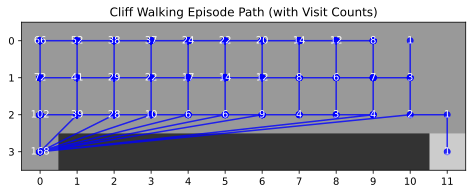

In [142]:
env = CliffWalkingEnv()

Q = np.zeros((env.height, env.width, len(env.actions)))

episode_path = env.generate_episode(Q, epsilon=1, print_episode=True)
env.plot_episode_path(episode_path) 

## SARSA

In [143]:
def sarsa(env, num_episodes, alpha, gamma, epsilon):
    Q = np.zeros((env.height, env.width, len(env.actions)))
    episode_rewards = np.zeros(num_episodes)
    for episode in range(num_episodes):
        state = env.reset()
        x, y = state
        action = env.choose_action_eps_greedy(Q, state, epsilon)  
        done = False
        total_reward = 0
        while not done:
            next_state, reward, done = env.step(action)
            next_action = env.choose_action_eps_greedy(Q, next_state, epsilon)
            next_action_index = env.actions.index(next_action)
            action_index = env.actions.index(action)
            Q[state][action_index] += alpha * (reward + gamma * Q[next_state][next_action_index] - Q[state][action_index])

            state = next_state
            action = next_action
            
            total_reward += reward
        episode_rewards[episode] = total_reward

    return Q, episode_rewards



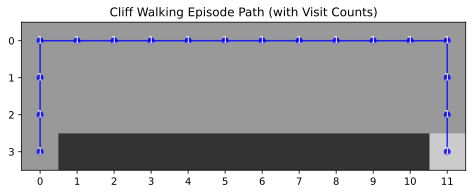

In [144]:
env = CliffWalkingEnv()
Q, episode_rewards = sarsa(env, num_episodes=5000, alpha=0.3, gamma=1, epsilon=0.1)
episode_path = env.generate_episode(Q, epsilon=0)
env.plot_episode_path(episode_path)

Running for alpha=0.1, epsilon=0.01
Running for alpha=0.1, epsilon=0.05
Running for alpha=0.1, epsilon=0.1
Running for alpha=0.3, epsilon=0.01
Running for alpha=0.3, epsilon=0.05
Running for alpha=0.3, epsilon=0.1
Running for alpha=0.5, epsilon=0.01
Running for alpha=0.5, epsilon=0.05
Running for alpha=0.5, epsilon=0.1


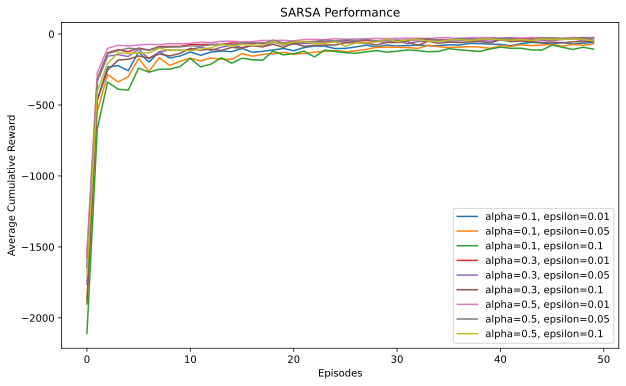

In [145]:
env = CliffWalkingEnv()
test_and_plot(env, sarsa, num_episodes=50, num_runs=50, title="SARSA Performance")

## Q Learning

In [40]:
def q_learning(env, num_episodes, alpha, gamma, epsilon):
    Q = np.zeros((env.height, env.width, len(env.actions)))  
    episode_rewards = np.zeros(num_episodes)
    alpha_none = alpha
    for episode in range(num_episodes):
        state = env.reset()
        done = False
        commulative_reward = 0
        time = 0
        while not done:
            action = env.choose_action_eps_greedy(Q, state, epsilon) 
            action_index = env.actions.index(action)
            next_state, reward, done = env.step(action)
            if alpha_none is None:
                alpha = 1/(1+time)
            greedy_q = np.max(Q[next_state])
            Q[state][action_index] += alpha * (reward + gamma * greedy_q - Q[state][action_index]) 
            state = next_state 
            commulative_reward += reward
            time += 1
        episode_rewards[episode] = commulative_reward
    return Q, episode_rewards

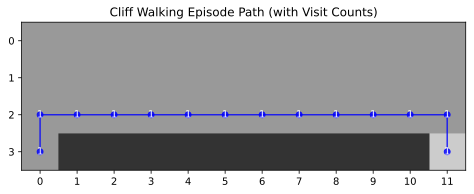

In [41]:
env = CliffWalkingEnv()
Q , _ = q_learning(env, num_episodes=2000, alpha=0.3, gamma=1, epsilon=0.1)
episode_path = env.generate_episode(Q, epsilon=0)
env.plot_episode_path(episode_path)

Running for alpha=None, epsilon=0.01
Running for alpha=None, epsilon=0.05
Running for alpha=None, epsilon=0.1
Running for alpha=0.1, epsilon=0.01
Running for alpha=0.1, epsilon=0.05
Running for alpha=0.1, epsilon=0.1
Running for alpha=0.3, epsilon=0.01
Running for alpha=0.3, epsilon=0.05
Running for alpha=0.3, epsilon=0.1
Running for alpha=0.5, epsilon=0.01
Running for alpha=0.5, epsilon=0.05
Running for alpha=0.5, epsilon=0.1


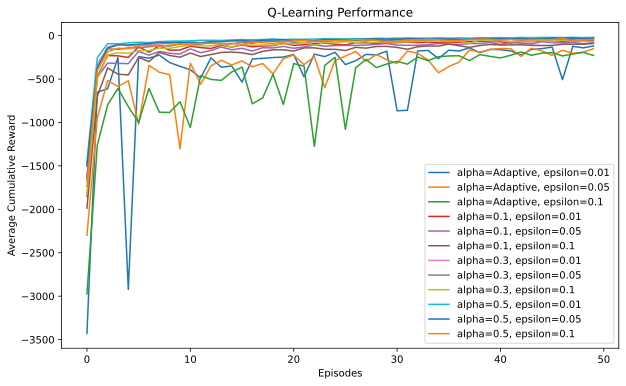

In [42]:
env = CliffWalkingEnv()
test_and_plot(env, q_learning, num_episodes=50, num_runs=80, alphas=[None, 0.1, 0.3, 0.5], title="Q-Learning Performance")

## Exercise 1 expected SARSA

![alt text](images/expected_sarsa1.PNG "Title")

In [43]:
def expected_sarsa(env, num_episodes, alpha, gamma, epsilon):
    Q = np.zeros((env.height, env.width, len(env.actions)))  
    episode_rewards = np.zeros(num_episodes)
    for episode in range(num_episodes):
        state = env.reset()
        done = False
        commulative_reward = 0
        while not done:
            action = env.choose_action_eps_greedy(Q, state, epsilon)
            action_index = env.actions.index(action)

            next_state, reward, done = env.step(action)

            expected_q_value = 0
            greedy_action = env.choose_action_eps_greedy(Q, next_state, 0)
            for a in env.actions:
                a_index = env.actions.index(a)
                policy_prob = epsilon/len(env.actions) + (1 - epsilon) if a == greedy_action else epsilon/len(env.actions) 
                expected_q_value += policy_prob * Q[next_state][a_index]

            Q[state][action_index] += alpha * (reward + gamma * expected_q_value - Q[state][action_index])

            state = next_state 
            commulative_reward += reward
        episode_rewards[episode] = commulative_reward
    return Q, episode_rewards

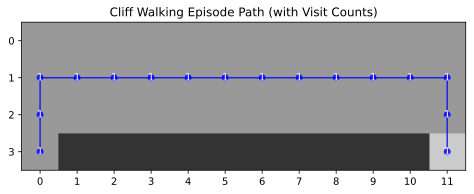

In [151]:
env = CliffWalkingEnv()
Q, _ = expected_sarsa(env, num_episodes=50000, alpha=0.3, gamma=1, epsilon=0.1)
episode_path = env.generate_episode(Q, epsilon=0)
env.plot_episode_path(episode_path)

Running for alpha=0.1, epsilon=0.01
Running for alpha=0.1, epsilon=0.05
Running for alpha=0.1, epsilon=0.1
Running for alpha=0.3, epsilon=0.01
Running for alpha=0.3, epsilon=0.05
Running for alpha=0.3, epsilon=0.1
Running for alpha=0.5, epsilon=0.01
Running for alpha=0.5, epsilon=0.05
Running for alpha=0.5, epsilon=0.1


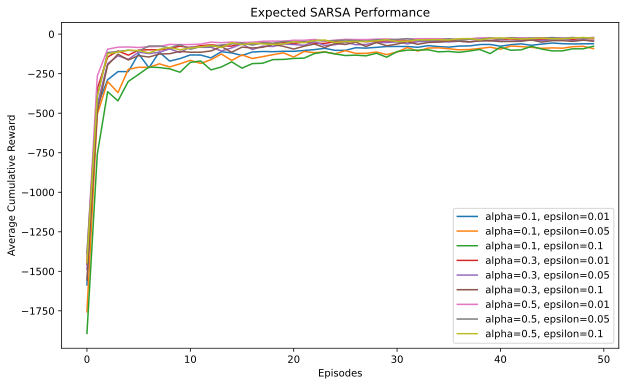

In [44]:
env = CliffWalkingEnv()
test_and_plot(env, expected_sarsa, num_episodes=50, num_runs=50, title="Expected SARSA Performance")

## Exercise 2 Double Q-learning

![alt text](images/double_q.PNG "Title")

In [153]:
def double_q_learning(env, num_episodes, alpha, gamma, epsilon):
    Q1 = np.zeros((env.height, env.width, len(env.actions)))
    Q2 = np.zeros((env.height, env.width, len(env.actions)))  
    episode_rewards = np.zeros(num_episodes)
    for episode in range(num_episodes):
        state = env.reset()
        done = False
        commulative_reward = 0
        while not done: 
            action = env.choose_action_double_q(Q1, Q2, state, epsilon) 

            next_state, reward, done = env.step(action)

            if random.random() < 0.5:
                argmax_action = env.actions[np.random.choice(np.flatnonzero(Q1[next_state] == Q1[next_state].max()))]
                Q1[state][env.actions.index(action)] += alpha * (reward + gamma * Q2[next_state][env.actions.index(argmax_action)] - Q1[state][env.actions.index(action)]) 
            else:
                argmax_action = env.actions[np.random.choice(np.flatnonzero(Q2[next_state] == Q2[next_state].max()))]
                Q2[state][env.actions.index(action)] += alpha * (reward + gamma * Q1[next_state][env.actions.index(argmax_action)] - Q2[state][env.actions.index(action)]) 

            state = next_state 
            commulative_reward += reward
        episode_rewards[episode] = commulative_reward


    return Q1, Q2, episode_rewards

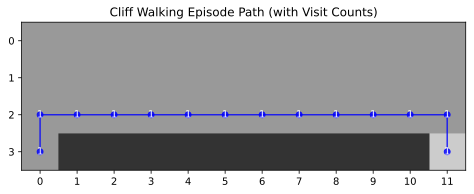

In [159]:
env = CliffWalkingEnv()
Q1, Q2, _ = double_q_learning(env, num_episodes=80000, alpha=0.5, gamma=1, epsilon=0.2)
episode_path = env.generate_episode(Q1+Q2, epsilon=0)
env.plot_episode_path(episode_path)

Running for alpha=0.1, epsilon=0.01
Running for alpha=0.1, epsilon=0.05
Running for alpha=0.1, epsilon=0.1
Running for alpha=0.3, epsilon=0.01
Running for alpha=0.3, epsilon=0.05
Running for alpha=0.3, epsilon=0.1
Running for alpha=0.5, epsilon=0.01
Running for alpha=0.5, epsilon=0.05
Running for alpha=0.5, epsilon=0.1


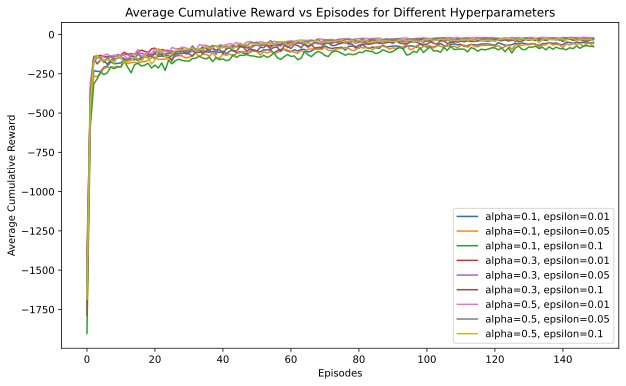

In [160]:
env = CliffWalkingEnv()
test_and_plot(env, double_q_learning, num_episodes=150, num_runs=50, title="Double Q-Learning Performance")

## Exercise 3 Speedy Q-Learning

![alt text](images//speedy_q.PNG "Title")

In [161]:
def speedy_q_learning(env, num_episodes, alpha, gamma, epsilon):
    Q = np.zeros((env.height, env.width, len(env.actions)))  
    previous_Q = Q.copy()
    episode_rewards = np.zeros(num_episodes)
    alpha_none = alpha
    for episode in range(num_episodes):
        state = env.reset()
        t = 0  
        done = False
        commulative_reward = 0
        while not done:
            action = env.choose_action_eps_greedy(Q, state, epsilon)
            action_index = env.actions.index(action)

            next_state, reward, done = env.step(action)
            if alpha_none is None:   
                alpha = 1 / (t + 1)
            bellman_update_Qt = reward + gamma * np.max(Q[next_state])      
            bellman_update_Qt_minus_1 = reward + gamma * np.max(previous_Q[next_state])   
            previous_Q = Q.copy() 
            Q[state][action_index] += alpha * (bellman_update_Qt_minus_1 - Q[state][action_index]) + \
                                      (1 - alpha) * (bellman_update_Qt - bellman_update_Qt_minus_1)
            t += 1
            state = next_state
            commulative_reward += reward
        episode_rewards[episode] = commulative_reward
            
    return Q, episode_rewards

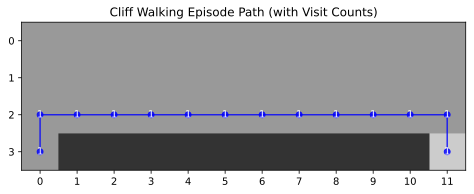

In [162]:
env = CliffWalkingEnv()
Q, _ = speedy_q_learning(env, num_episodes=50000, alpha=1, gamma=1, epsilon=0.1)
episode_path = env.generate_episode(Q, epsilon=0)
env.plot_episode_path(episode_path)

Running for alpha=None, epsilon=0.01
Running for alpha=None, epsilon=0.05
Running for alpha=None, epsilon=0.01
Running for alpha=0.1, epsilon=0.01
Running for alpha=0.1, epsilon=0.05
Running for alpha=0.1, epsilon=0.01
Running for alpha=0.3, epsilon=0.01
Running for alpha=0.3, epsilon=0.05
Running for alpha=0.3, epsilon=0.01
Running for alpha=0.5, epsilon=0.01
Running for alpha=0.5, epsilon=0.05
Running for alpha=0.5, epsilon=0.01


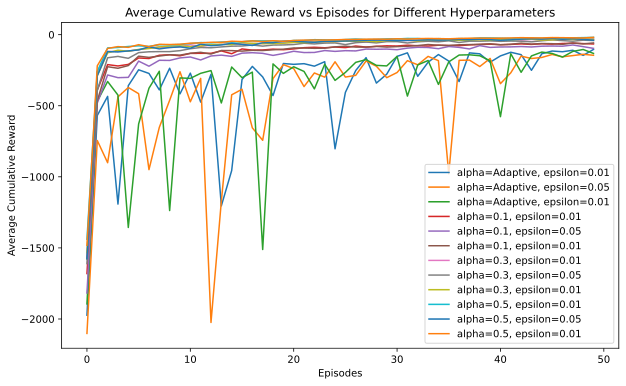

In [163]:
env = CliffWalkingEnv()
test_and_plot(env, speedy_q_learning, num_episodes=50, num_runs=100, alphas=[None, 0.1, 0.3, 0.5], epsilons=[0.01, 0.05, 0.01])

In [164]:
def test_and_plot_q_comparison(env, num_episodes, num_runs=100, alphas = [None, 0.1, 0.3, 0.5], epsilons=[0.01, 0.1], title=None):
    alpha_values = alphas
    epsilon_values = epsilons

    results_q_learning = []
    results_double_q_learning = []
    print("Q-learning")
    for alpha in alpha_values:
        for epsilon in epsilon_values:
            rewards_all_runs = []
            print(f"Running for alpha={alpha}, epsilon={epsilon}")
            for _ in range(num_runs):
                rewards = q_learning(env, num_episodes=num_episodes, alpha=alpha, gamma=1, epsilon=epsilon)[-1]
                rewards_all_runs.append(rewards)

            avg_rewards = np.mean(rewards_all_runs, axis=0)
            result = [avg_rewards, alpha, epsilon, "q_learning"]  
            results_q_learning.append(result)
    print("Double Q-learning")
    for alpha in alpha_values:
        for epsilon in epsilon_values:
            rewards_all_runs = []
            print(f"Running for alpha={alpha}, epsilon={epsilon}")
            for _ in range(num_runs):
                rewards = q_learning(env, num_episodes=num_episodes, alpha=alpha, gamma=1, epsilon=epsilon)[-1]
                rewards_all_runs.append(rewards)

            avg_rewards = np.mean(rewards_all_runs, axis=0)
            result = [avg_rewards, alpha, epsilon, "double_q_learning"]  
            results_double_q_learning.append(result)

    fig, ax = plt.subplots(figsize=(10, 6)) 

    for rewards, alpha, epsilon, method in results_double_q_learning+results_q_learning:
        if alpha is None:
            alpha = "Adaptive"
        ax.plot(rewards, label=f"alpha={alpha}, epsilon={epsilon}, method={method}")  

    ax.set_xlabel("Episodes")
    ax.set_ylabel("Average Cumulative Reward")  
    ax.legend()
    if title:
        ax.set_title(title)
    else:
        ax.set_title("Average Cumulative Reward vs Episodes for Different Hyperparameters")
    plt.show()

Q-learning
Running for alpha=None, epsilon=0.01
Running for alpha=0.1, epsilon=0.01
Running for alpha=0.5, epsilon=0.01
Running for alpha=1, epsilon=0.01
Double Q-learning
Running for alpha=None, epsilon=0.01
Running for alpha=0.1, epsilon=0.01
Running for alpha=0.5, epsilon=0.01
Running for alpha=1, epsilon=0.01


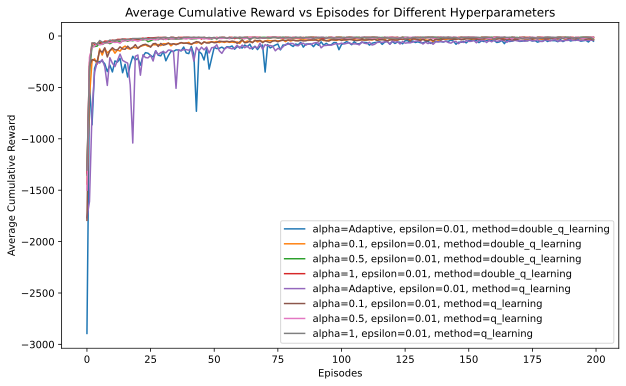

In [165]:
test_and_plot_q_comparison(env, num_episodes=200, num_runs=20, alphas=[None, 0.1, 0.5, 1], epsilons=[0.01])

## Exercise 4

In [166]:
def get_average_rewards(env, num_episodes, num_runs, method, alpha, gamma, epsilon):
    rewards_all_runs = []
    for _ in range(num_runs):
        rewards = method(env, num_episodes=num_episodes, alpha=alpha, gamma=gamma, epsilon=epsilon)[-1]
        rewards_all_runs.append(rewards)
    avg_rewards = np.mean(rewards_all_runs, axis=0)
    return avg_rewards


def algo_comp(env, num_episodes, num_runs=100, alphas = [None, 0.1, 0.3, 0.5], epsilons=[0.01, 0.1], title=None):
    alpha_values = alphas
    epsilon_values = epsilons

    results = []
    print("Q-learning")
    alpha = 0.5
    epsilon = 0.01
    q_learning_rewards = get_average_rewards(env, num_episodes, num_runs, q_learning, alpha, 1, epsilon)
    result = [q_learning_rewards, alpha, epsilon, "q_learning"]  
    results.append(result)

    print("Double Q-learning")
    alpha = 0.5
    epsilon = 0.01
    double_q_learning_rewards = get_average_rewards(env, num_episodes, num_runs, double_q_learning, alpha, 1, epsilon)
    result = [double_q_learning_rewards, alpha, epsilon, "double_q_learning"]
    results.append(result)

    print("Expected Sarsa")
    alpha = 0.5
    epsilon = 0.01
    expected_sarsa_rewards = get_average_rewards(env, num_episodes, num_runs, expected_sarsa, alpha, 1, epsilon)
    result = [expected_sarsa_rewards, alpha, epsilon, "expected_sarsa"]
    results.append(result)

    print("Sarsa")
    alpha = 0.5
    epsilon = 0.01
    sarsa_rewards = get_average_rewards(env, num_episodes, num_runs, sarsa, alpha, 1, epsilon)
    result = [sarsa_rewards, alpha, epsilon, "sarsa"]
    results.append(result)

    fig, ax = plt.subplots(figsize=(10, 6)) 

    for rewards, alpha, epsilon, method in results:
        if alpha is None:
            alpha = "Adaptive"
        ax.plot(rewards, label=f"alpha={alpha}, epsilon={epsilon}, method={method}")  

    ax.set_xlabel("Episodes")
    ax.set_ylabel("Average Cumulative Reward")  
    ax.legend()
    if title:
        ax.set_title(title)
    else:
        ax.set_title("Average Cumulative Reward vs Episodes for Different Hyperparameters")
    plt.show()

Q-learning
Double Q-learning
Expected Sarsa
Sarsa


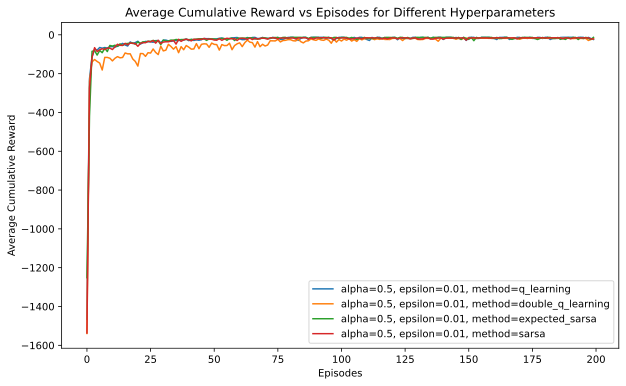

In [167]:
env = CliffWalkingEnv()
algo_comp(env, num_episodes=200, num_runs=20)